In [1]:
"""
Author https://github.com/boguss1225
Reference : https://keras.io/examples/vision/image_classification_from_scratch/
"""
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import config

2023-01-03 12:14:56.057072: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-03 12:14:57.010947: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-01-03 12:14:57.011016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib64
2023-01-03 12:14:57.011022: W tensorflow/c

In [10]:
image_size = (config.image_width, config.image_height)
train_ds, val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    config.train_dir,
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=config.BATCH_SIZE,
)

Found 2694 files belonging to 2 classes.
Using 2156 files for training.
Using 538 files for validation.


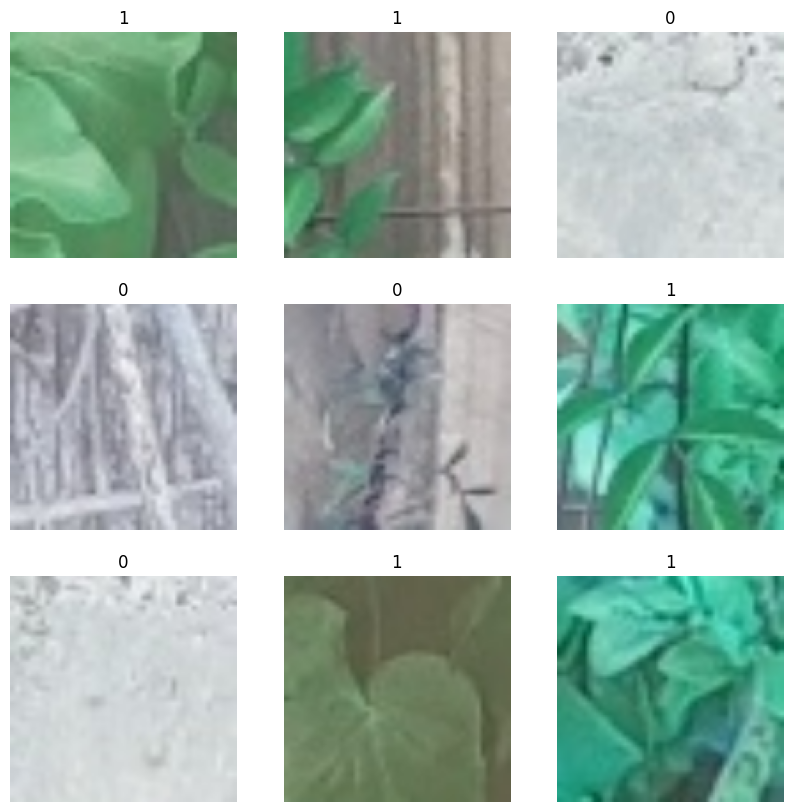

In [5]:
"""
## Visualize the data
Here are the first 9 images in the training dataset. 
Label 0 : "wall".
Label 1 : "vegetation".
"""
if config.BATCH_SIZE > 9 :
    range_val = 9
else :
    range_val = config.BATCH_SIZE

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(range_val):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [6]:
"""
Apply image data augmentation
"""

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.3),
        layers.RandomBrightness(factor=0.2),
        layers.RandomContrast(factor=0.2)
    ]
)

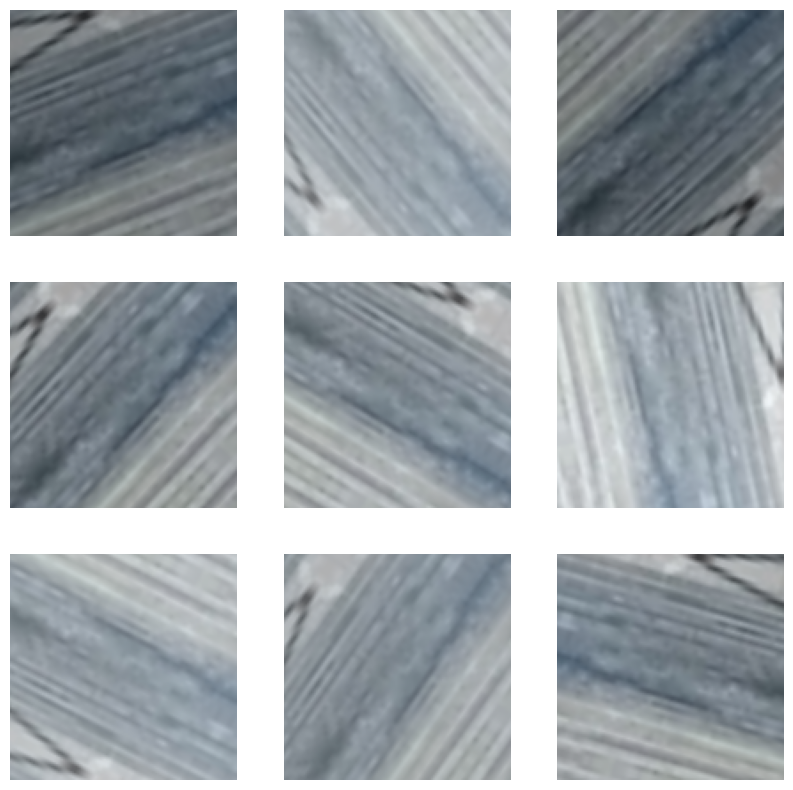

In [8]:
"""
Visualize augmented samples; the first image in the dataset
"""

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(range_val):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")


In [6]:
"""
## Configure the dataset for performance
Apply data augmentation to our training dataset,
Use buffered prefetching so we can yield data from disk without
having I/O becoming blocking:
"""

# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


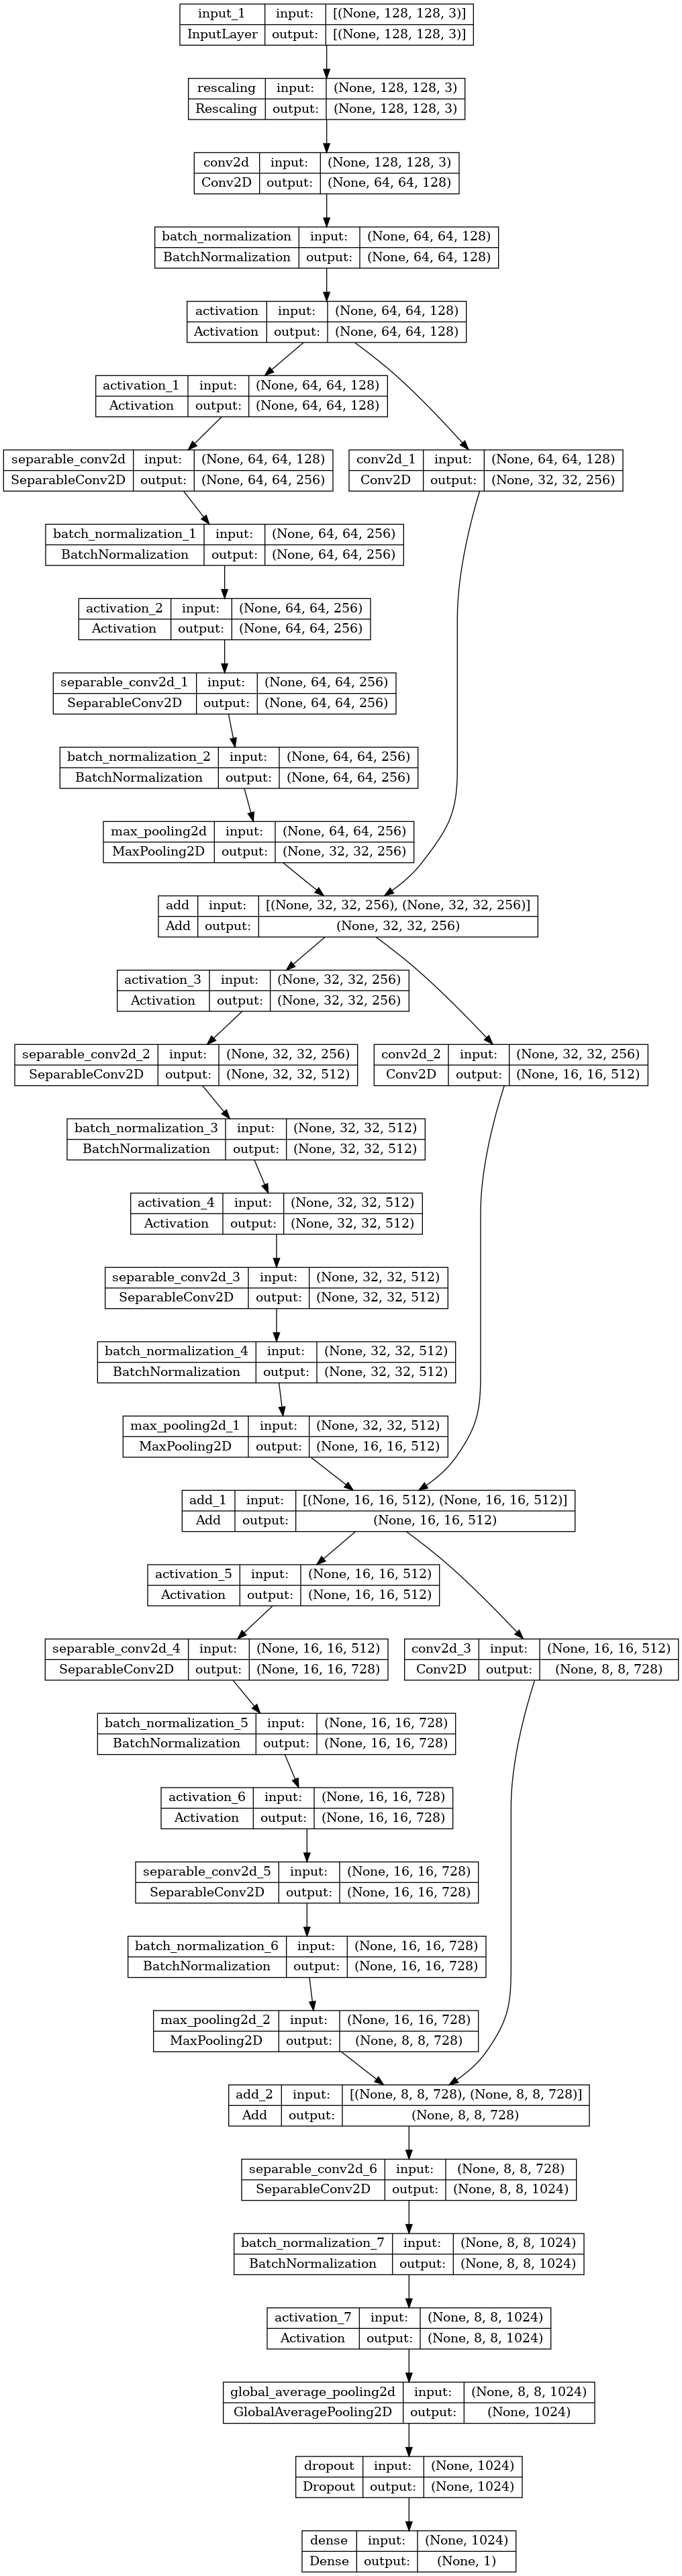

In [11]:
"""
## Build a model
Small version of the Xception network. We haven't particularly tried to
optimize the architecture; if you want to do a systematic search for the best model
configuration, consider using
[KerasTuner](https://github.com/keras-team/keras-tuner).
Note that:
- We start the model with the `data_augmentation` preprocessor, followed by a
 `Rescaling` layer.
- We include a `Dropout` layer before the final classification layer.
"""


def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=config.NUM_CLASSES)
keras.utils.plot_model(model, show_shapes=True)

In [13]:
"""
Callbacks
"""

# tensorboard = tf.keras.callbacks.TensorBoard(log_dir='log')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=config.model_dir+config.model_save_name+".keras",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss",
    patience=20,
    restore_best_weights=True
)

callbacks = [
#     tensorboard, 
    model_checkpoint_callback, 
    early_stop_callback
]

In [26]:
"""
## Train the model
"""
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2" #GPU Selection

epochs = 10

if config.NUM_CLASSES == 2 :
    loss = "binary_crossentropy"
else :
    loss = "sparse_categorical_crossentropy"

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=loss,
    metrics=["accuracy", # add more metrics if you want
             tf.keras.metrics.AUC(),
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()],
)

# if you want to load weight
# model.load_weights(config.model_dir+"ivy_30.keras")
# print("load weights successful")

# mkdir for model save path
if not os.path.exists(config.model_dir):
    os.makedirs(config.model_dir)
    
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/10
135/135 [==============================] - 10s 26ms/step - loss: 0.0221 - accuracy: 0.9907 - auc_6: 0.9997 - precision_6: 0.9899 - recall_6: 0.9917 - val_loss: 0.0686 - val_accuracy: 0.9777 - val_auc_6: 0.9976 - val_precision_6: 0.9615 - val_recall_6: 0.9964
Epoch 2/10
135/135 [==============================] - 3s 23ms/step - loss: 0.0308 - accuracy: 0.9907 - auc_6: 0.9991 - precision_6: 0.9908 - recall_6: 0.9908 - val_loss: 0.1403 - val_accuracy: 0.9480 - val_auc_6: 0.9990 - val_precision_6: 0.9106 - val_recall_6: 0.9964
Epoch 3/10
135/135 [==============================] - 3s 23ms/step - loss: 0.0156 - accuracy: 0.9935 - auc_6: 0.9999 - precision_6: 0.9936 - recall_6: 0.9936 - val_loss: 0.0519 - val_accuracy: 0.9740 - val_auc_6: 0.9996 - val_precision_6: 0.9549 - val_recall_6: 0.9964
Epoch 4/10
135/135 [==============================] - 3s 23ms/step - loss: 0.0175 - accuracy: 0.9926 - auc_6: 0.9998 - precision_6: 0.9935 - recall_6: 0.9917 - val_loss: 0.0386 - val_accuracy:

In [27]:
"""
## Run inference on new data
! Note that data augmentation and dropout are inactive at inference time.
"""
img = keras.preprocessing.image.load_img(
    config.test_image_path, target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
if config.NUM_CLASSES == 2 :
    score = float(predictions[0])
    print(f"[{config.test_image_path}] is {100 * (1 - score):.2f}% bg and {100 * score:.2f}% vegetation.")
else :
    # TO_DO for multi-class classification

1/1 [==============================] - 0s 188ms/step
[/home/mirap/0_DATABASE/ivy_coverage/cropped/test/ivy/resultsivy_006_2112.jpg] is 0.00% bg and 100.00% ivy.
